# ViT from scratch, step by step

In [1]:
import os
import sys
from pathlib import Path

repo_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
core_path = os.path.join(repo_root, 'core')
if repo_root not in sys.path:
    sys.path.append(repo_root)
    
if core_path not in sys.path:
    sys.path.append(core_path)
    
# set auto reaload of modules
%load_ext autoreload
%autoreload 2

%matplotlib inline

Check torch version:

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch as t
    import torchvision
    assert int(t.__version__.split(".")[1]) >= 12 or int(t.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {t.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except Exception as e:
    print(f"[INFO] Error: {e}")
    print("[INFO] torch/torchvision versions not as required, installing nightly versions.")
    %pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch as t
    import torchvision
    print(f"torch version: {t.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cu128
torchvision version: 0.23.0+cu128


Check that `torchinfo` is installed + import the necessary code:

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch as t
import torchvision

from torch import nn
from torchvision import transforms
from core import data_setup, engine
from core.utils import download_data, set_seeds, plot_loss_curves

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

/workspace/vit-from-scratch/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/workspace/vit-from-scratch/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened becau

In [4]:
device = "cuda" if t.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Setup seed for reproducibility
set_seeds()

## Get Data

In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] ../data/pizza_steak_sushi directory exists, skipping download.


PosixPath('../data/pizza_steak_sushi')

In [7]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## Datasets and DataLoaders

From the paper (table 3):
- training img dim = 224
- batch size = 4096

In [8]:
from torchvision import transforms

IMG_DIM = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_DIM, IMG_DIM)),
    transforms.ToTensor(),
])

In [9]:
BATCH_SIZE = 32 # <-- cuz of hw limits lol
NUM_WORKERS = 4

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transforms=manual_transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

train_dataloader, test_dataloader, class_names

Class names: ['pizza', 'steak', 'sushi']


(<torch.utils.data.dataloader.DataLoader at 0x7f8aa6e53210>,
 ['pizza', 'steak', 'sushi'])

torch.Size([3, 224, 224]) tensor(2)


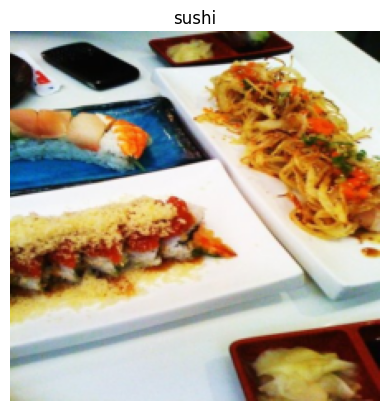

In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# rearrange image dimensions to suit matplotlib 
# [color_channels, height, width] -> [height, width, color_channels]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Implementation: overview

Main equations to implement:
$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)+\mathbf{z}_{\ell-1},\right. & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$

## Equation 1: prepare input (flattened image patches embeddings)

let's calculate how many patches we would get, considering we will replicate the base version of ViT.

In [11]:
H = 224  # height
W = 224  # width
P = 16   # patch size
C = 3    # number of channels (RGB)
N = (H * W) // (P * P)  # number of patches

print(f"Number of patches: {N}")

Number of patches: 196


translated into the dimensions of our input (the image itself) and the output (the flattened/patched version):

In [12]:
image_shape = (H, W, 3)  # assuming 3 color channels (RGB)
patch_size = (N, (P**2 * C))

print("Input shape (the image itself):", image_shape)
print("Output shape (the flattened/patched version):", patch_size)

Input shape (the image itself): (224, 224, 3)
Output shape (the flattened/patched version): (196, 768)


### Turning the image into patches

plain image

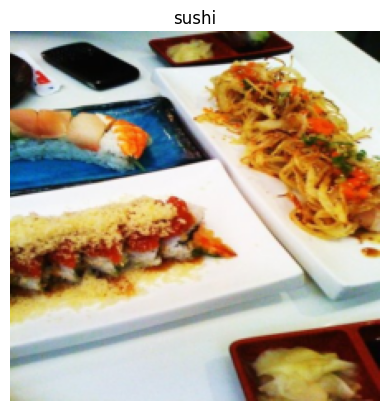

In [13]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

top row of patched pixels

(np.float64(-0.5), np.float64(223.5), np.float64(15.5), np.float64(-0.5))

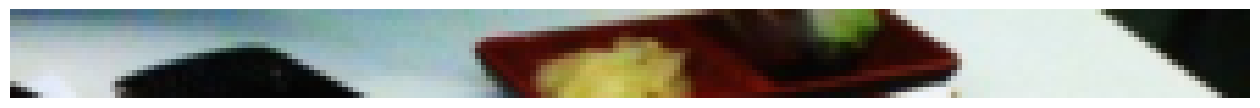

In [14]:
img_permuted = image.permute(1, 2, 0)  # [H, W, C]

plt.figure(figsize=(P, P))
plt.imshow(img_permuted[:P, :, :])  # top-left patch
plt.axis(False)

let's patchify the top row:

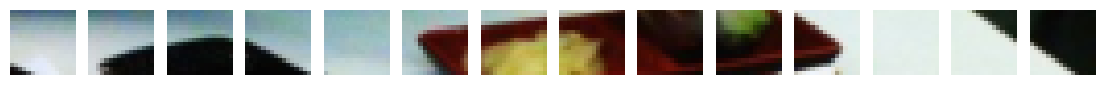

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."

fig, axs = plt.subplots(
    nrows=1,
    ncols=int(num_patches), 
    figsize=(num_patches, 1)
)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(img_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].axis(False)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Let's do it for the whole image

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


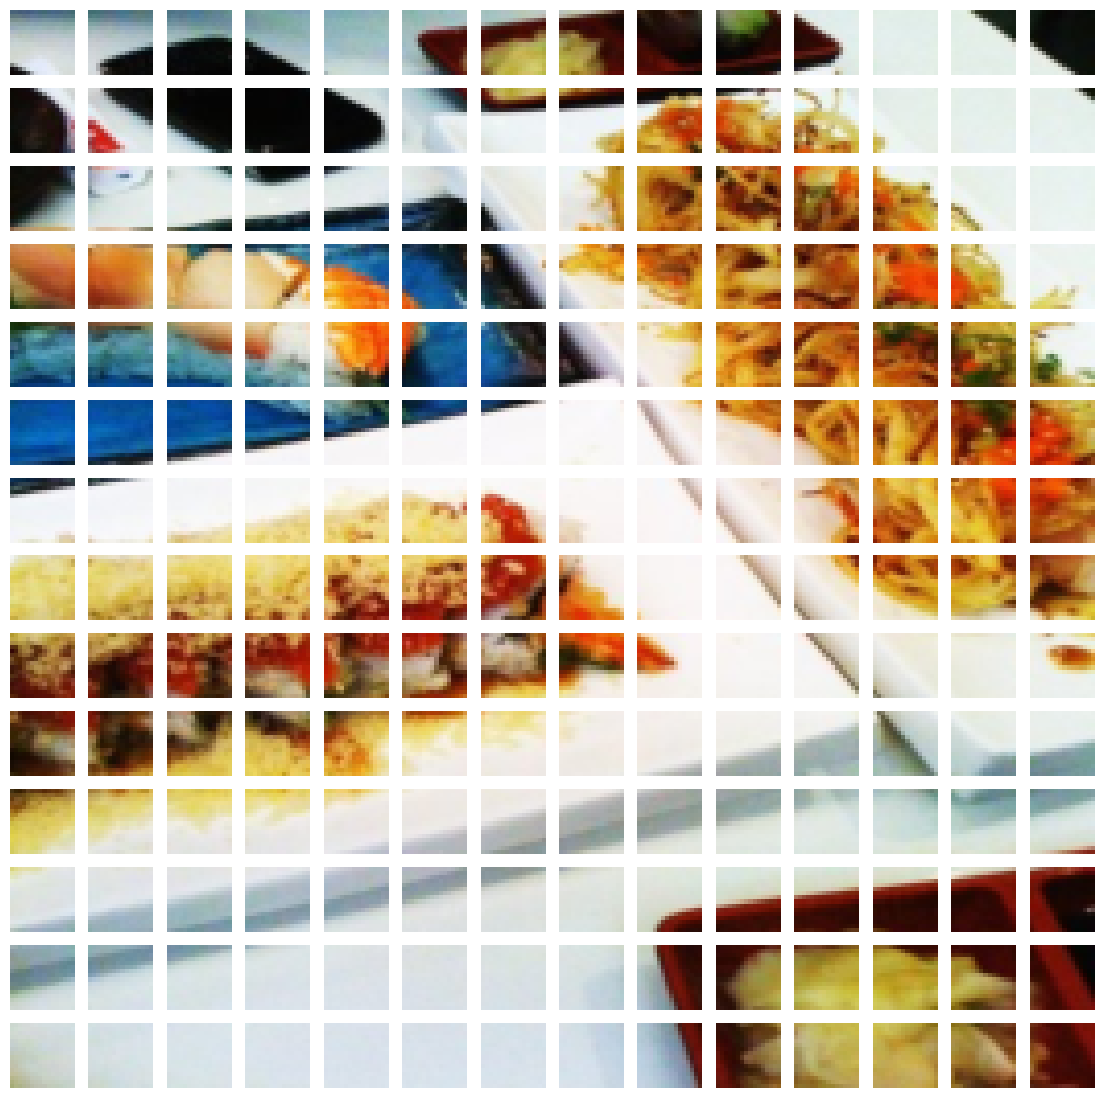

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(
    nrows= img_size // patch_size,
    ncols= img_size // patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

for i, row in enumerate(range(0, img_size, patch_size)):
    for j, col in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(img_permuted[row:row+patch_size, col:col+patch_size, :])
        axs[i, j].axis(False)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

### Creating image patches using `Conv2D`

We can recreate what we have above with:
- `t.nn.Conv2d()` -> turining the image into CNN feature maps of dimension `P`
- `t.nn.Flatten()` -> flattening the spatial dim of the feature maps.

For the `Conv2d()` part:

Feature map shape: torch.Size([1, 768, 14, 14])


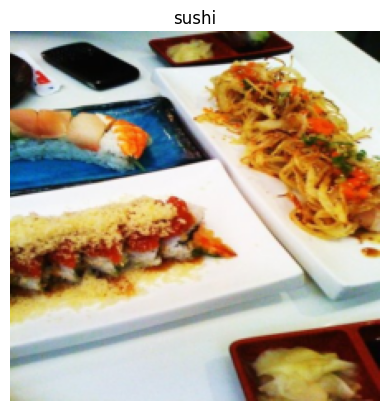

In [17]:
embed_dim = 768
conv_2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0,
)

feature_maps = conv_2d(image.unsqueeze(0))
print(f"Feature map shape: {feature_maps.shape}")

# visualize the image
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)
plt.title(class_names[label])
plt.show()

visualizing 5 of the random feature maps obtained:

Random indices: [347, 135, 17, 242, 489]


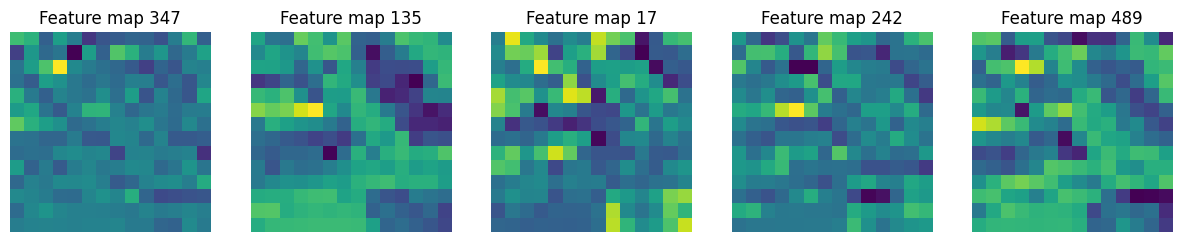

In [18]:
import random

random_idx = random.sample(range(0, embed_dim), 5)
print("Random indices:", random_idx)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

for i, idx in enumerate(random_idx):
    axs[i].imshow(feature_maps[0, idx, :, :].detach().numpy())
    axs[i].set_title(f"Feature map {idx}")
    axs[i].axis(False)

In [19]:
# Get a single feature map in tensor form
single_feature_map = feature_maps[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.8176, -0.6418, -0.4872, -0.5758, -0.7243, -0.4365, -0.2517,
           -0.1883, -0.1010, -0.2052, -0.3501, -0.9703, -1.1312, -0.1001],
          [ 0.1144, -1.0577, -0.0710,  0.0083,  0.0727, -0.9256, -0.6416,
           -0.8521, -0.8934, -0.7018, -0.9052, -0.9847, -0.9749, -1.0478],
          [-0.1704, -0.8053, -0.8679, -0.8285, -0.9246, -0.6688, -0.9587,
           -1.0630, -0.5454, -0.4330, -0.4856, -0.5460, -0.9633, -0.9834],
          [-0.4468, -0.6124, -0.8217, -0.9025, -0.7151, -0.4206,  0.0774,
           -0.9059, -0.6263, -0.5677, -0.6230, -0.7193, -0.5842, -0.9423],
          [-0.3769, -0.3758, -0.4067, -0.5090, -0.7041, -0.1277, -0.2635,
           -0.5493, -1.1305, -0.7572, -0.6042, -0.3964, -0.3973, -1.0628],
          [-0.1667, -0.2729, -0.4155, -0.3927, -0.3325, -0.8999, -1.0067,
           -1.0335, -0.9814, -0.9558, -0.5720, -0.5380, -0.5040, -0.5470],
          [-1.0526, -1.0946, -1.0253, -1.0834, -0.9792, -0.9339, -0.6786,
           -1.0560, -1.0755, -0.

now we need to flatten the spatial dimension of the feature maps, which are:
- feature maps' height
- feature maps' width.

We use `nn.Flatten()` for this. We just need to remember that the desired output is `(196, 768)` (aka: for each patch, we have an emb of dimension 768).

In [20]:
flatten = nn.Flatten(
    start_dim=2, # H
    end_dim=3 # W
)

flattened_feature_maps = flatten(conv_2d(image.unsqueeze(0)))
print(f"Flattened feature maps shape: {flattened_feature_maps.shape}")

# permute to get (num_patches, embed_dim)
flattened_feature_maps = flattened_feature_maps.permute(0, 2, 1)
print(f"Permuted flattened feature maps shape: {flattened_feature_maps.shape}") # -> [B, N, P^2*C]

Flattened feature maps shape: torch.Size([1, 768, 196])
Permuted flattened feature maps shape: torch.Size([1, 196, 768])


result in image form:

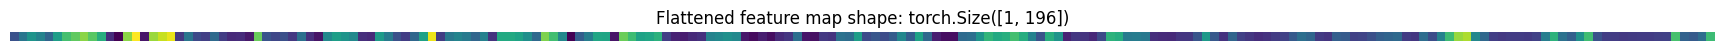

In [21]:
# Get a single flattened feature map
single_flattened_feature_map = flattened_feature_maps[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy(), cmap='viridis')
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

result in tensor form:

In [22]:
single_feature_map.shape, single_flattened_feature_map, single_flattened_feature_map.requires_grad

(torch.Size([1, 14, 14]),
 tensor([[-0.8176, -0.6418, -0.4872, -0.5758, -0.7243, -0.4365, -0.2517, -0.1883,
          -0.1010, -0.2052, -0.3501, -0.9703, -1.1312, -0.1001,  0.1144, -1.0577,
          -0.0710,  0.0083,  0.0727, -0.9256, -0.6416, -0.8521, -0.8934, -0.7018,
          -0.9052, -0.9847, -0.9749, -1.0478, -0.1704, -0.8053, -0.8679, -0.8285,
          -0.9246, -0.6688, -0.9587, -1.0630, -0.5454, -0.4330, -0.4856, -0.5460,
          -0.9633, -0.9834, -0.4468, -0.6124, -0.8217, -0.9025, -0.7151, -0.4206,
           0.0774, -0.9059, -0.6263, -0.5677, -0.6230, -0.7193, -0.5842, -0.9423,
          -0.3769, -0.3758, -0.4067, -0.5090, -0.7041, -0.1277, -0.2635, -0.5493,
          -1.1305, -0.7572, -0.6042, -0.3964, -0.3973, -1.0628, -0.1667, -0.2729,
          -0.4155, -0.3927, -0.3325, -0.8999, -1.0067, -1.0335, -0.9814, -0.9558,
          -0.5720, -0.5380, -0.5040, -0.5470, -1.0526, -1.0946, -1.0253, -1.0834,
          -0.9792, -0.9339, -0.6786, -1.0560, -1.0755, -0.9244, -0.9415,

Finally, we modularize the `PatchEmbedding` thing:

torch.Size([1, 196, 768]) tensor([[[ 0.6096, -0.1588, -0.4739,  ...,  0.6895,  0.2181, -0.1245],
         [ 0.5337, -0.0242, -0.7186,  ...,  0.4584,  0.3779, -0.2824],
         [ 0.0704, -0.0147, -0.3385,  ...,  0.1023,  0.3660,  0.1390],
         ...,
         [ 0.3806, -0.1637, -0.5343,  ...,  0.5527,  0.1557, -0.0821],
         [ 0.3234, -0.0631, -0.2819,  ...,  0.3920,  0.2609, -0.0500],
         [ 0.0698,  0.0578, -0.2199,  ...,  0.1429, -0.0180,  0.0352]]],
       grad_fn=<PermuteBackward0>)


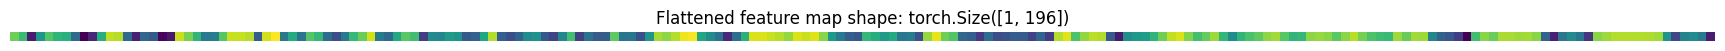

In [23]:
from core.vit import PatchEmbedding

# Get a single flattened feature map
patch_embedder = PatchEmbedding(
    in_channels=3,
    emb_size=embed_dim,
    patch_size=P,
)

emb_img = patch_embedder(image.unsqueeze(0))

# Check out the embedding
print(emb_img.shape, emb_img)

# "visualize the embedding" of the first embedding vector
plt.figure(figsize=(22, 22))
plt.imshow(emb_img[:, :, 0].detach().numpy(), cmap='viridis')
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

With this we replicated the PatchEmb but not the position encoding nor the class token emb. yet.

### Creating the class token embedding

In [24]:
# get batch size and emb_dim of the image embedding
batch_size, emb_dim = emb_img.shape[0], emb_img.shape[-1]

# create the class token embedding (in practice we would use t.randn and learn it)
class_token = nn.Parameter(t.ones(batch_size, 1, emb_dim))

# prepend the class emb to the image embedding
emb_img_with_class = t.cat((class_token, emb_img), dim=1)
emb_img_with_class.shape, emb_img_with_class

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.6096, -0.1588, -0.4739,  ...,  0.6895,  0.2181, -0.1245],
          [ 0.5337, -0.0242, -0.7186,  ...,  0.4584,  0.3779, -0.2824],
          ...,
          [ 0.3806, -0.1637, -0.5343,  ...,  0.5527,  0.1557, -0.0821],
          [ 0.3234, -0.0631, -0.2819,  ...,  0.3920,  0.2609, -0.0500],
          [ 0.0698,  0.0578, -0.2199,  ...,  0.1429, -0.0180,  0.0352]]],
        grad_fn=<CatBackward0>))

### Creating the position embedding

out embeddings so far:

In [25]:
emb_img_with_class, emb_img_with_class.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.6096, -0.1588, -0.4739,  ...,  0.6895,  0.2181, -0.1245],
          [ 0.5337, -0.0242, -0.7186,  ...,  0.4584,  0.3779, -0.2824],
          ...,
          [ 0.3806, -0.1637, -0.5343,  ...,  0.5527,  0.1557, -0.0821],
          [ 0.3234, -0.0631, -0.2819,  ...,  0.3920,  0.2609, -0.0500],
          [ 0.0698,  0.0578, -0.2199,  ...,  0.1429, -0.0180,  0.0352]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

To the pos emb now:

In [26]:
batch_size = emb_img_with_class.shape[0]
emb_dim = emb_img_with_class.shape[-1]
num_patches = int(H*W/(P*P))

# in this case, one random starting emb per patch
pos_emb = nn.Parameter(t.ones(
    batch_size, 
    num_patches + 1, 
    emb_dim
))

pos_emb.shape, pos_emb[:, :10, :]

(torch.Size([1, 197, 768]),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], grad_fn=<SliceBackward0>))

and finally we add patch and pos emb:

In [27]:
patch_and_pos_emb = emb_img_with_class + pos_emb
patch_and_pos_emb.shape, patch_and_pos_emb

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.6096, 0.8412, 0.5261,  ..., 1.6895, 1.2181, 0.8755],
          [1.5337, 0.9758, 0.2814,  ..., 1.4584, 1.3779, 0.7176],
          ...,
          [1.3806, 0.8363, 0.4657,  ..., 1.5527, 1.1557, 0.9179],
          [1.3234, 0.9369, 0.7181,  ..., 1.3920, 1.2609, 0.9500],
          [1.0698, 1.0578, 0.7801,  ..., 1.1429, 0.9820, 1.0352]]],
        grad_fn=<AddBackward0>))

### Summary

SO, to summarize we implement the first equation:

$$
\begin{aligned}
    \mathbf{z}_0 &= \left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right] + \mathbf{E}_{\text {pos }},& 
    \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \quad \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

in the following way:

In [28]:
set_seeds()

C = 3
emb_dim = 768 # -> following the ViT-base configuration
patch_size = 16

img_emb = PatchEmbedding(
    in_channels=3,
    emb_size=emb_dim,
    patch_size=patch_size,
)(image.unsqueeze(0))

class_emb = nn.Parameter(t.ones(1, 1, emb_dim))
img_emb_with_class = t.cat((class_emb, img_emb), dim=1)

num_patches = img_emb_with_class.shape[1]
pos_emb = nn.Parameter(t.ones(1, num_patches, emb_dim))

patch_and_pos_emb = img_emb_with_class + pos_emb
patch_and_pos_emb.shape, patch_and_pos_emb

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.1898, 1.1702, 0.7528,  ..., 1.5219, 0.6954, 1.3604],
          [0.2534, 1.1335, 0.9539,  ..., 1.1018, 0.9026, 1.2948],
          ...,
          [0.3991, 1.1046, 0.7861,  ..., 1.4524, 0.6780, 1.2710],
          [0.4800, 1.0405, 0.8942,  ..., 1.3475, 0.7893, 1.1108],
          [0.8555, 1.0100, 0.9064,  ..., 0.9751, 0.8778, 1.1604]]],
        grad_fn=<AddBackward0>))

## Equation 2: Multiheaded Self Attn (MSA)

Next equation thingy to implement:
$$
    \begin{aligned}
    \mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)+\mathbf{z}_{\ell-1},\right. & & \ell=1 \ldots L
    \end{aligned}
$$

done in `vit.py` with the class `MultiheadSelfAttention`.

In [29]:
from core.vit import MultiheadSelfAttentionBlock

msa_block = MultiheadSelfAttentionBlock(emb_size=emb_dim, num_heads=12)
msa_out = msa_block(patch_and_pos_emb)

print(f"Input shape: {patch_and_pos_emb.shape}")
print(f"Output shape: {msa_out.shape}")

Input shape: torch.Size([1, 197, 768])
Output shape: torch.Size([1, 197, 768])


## Equation 3: MLP

The equation:
$$
    \begin{aligned}
        \mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}
    \end{aligned}
$$
The implementation:

In [30]:
from core.vit import MLPBlock

mlp_block = MLPBlock(emb_size=emb_dim, mlp_size=3072, dropout=0.1)

mlp_out = mlp_block(msa_out)
print(f"Input shape: {msa_out.shape}")
print(f"Output shape: {mlp_out.shape}")

Input shape: torch.Size([1, 197, 768])
Output shape: torch.Size([1, 197, 768])


## Creating a Transfomer Encoder block

That's basically to put the 2 equations together with the skip connections as well.

In [31]:
from core.vit import TransformerEncoderBlock

transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_data=patch_and_pos_emb,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (ln)                              [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)                    [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (ln)                              [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

Same thing, but by only using PyTorch:

In [32]:
from torch.nn import TransformerEncoderLayer

enc_block = TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, dropout=0.1, activation='gelu', batch_first=True)
summary(model=enc_block,
        input_data=patch_and_pos_emb,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                                 [1, 197, 3072]       [1, 197, 768]        2,360,064            True
├─Dropout (dropout2)                           

## Putting things together

In [33]:
from core.vit import ViT

set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = t.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(n_classes=len(class_names))

# Pass the random image tensor to our ViT instance
output = vit(random_image_tensor)

print(f"Output shape: {output}")

Output shape: tensor([[0.9497, 0.0399, 0.5830]], grad_fn=<AddmmBackward0>)


Lil summary of the model:

In [34]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (conv2d)                                  [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (emb_dropout)                                 [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (model)                                    [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    │ 

Printing the summary of the original ViT from the `torchvision` library, just to compare:

In [35]:
from torchvision.models import vit_b_16

original_vit = vit_b_16(weights="IMAGENET1K_V1") # weights="IMAGENET1K_V1" to get the pretrained weights
original_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

summary(model=original_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

## Setting up for training

For now I will be setup and start running a very naive setup, with the basic parameters for the optimizer as shown in the paper.

In [36]:
from core.engine import ModelTrainer, TrainingArgs

training_args = TrainingArgs(
    lr=3e-3, # from table 3 of the paper (ViT-* ImageNet-1k)
    n_epochs=10,
    device=device,
    weight_decay=0.3,
)

# params from the paper specifics (section 4.1)
optimizer = t.optim.Adam(
    params=vit.parameters(), 
    lr=training_args.lr,
    betas=(0.9, 0.999),
    weight_decay=training_args.weight_decay,
)

loss_fn = nn.CrossEntropyLoss()

set_seeds()

model_trainer = ModelTrainer(
    model=vit,
    args=training_args,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer
)

results = model_trainer.train()

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Validation: loss = 0.9982, accuracy = 0.5417
--------------------------------------------------


Epoch 1/10: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s, loss=32.3, step=8]


Training: loss = 4.0722, accuracy = 0.4336


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Validation: loss = 4.1042, accuracy = 0.1979
--------------------------------------------------


Epoch 2/10: 100%|██████████| 8/8 [00:04<00:00,  1.62it/s, loss=11, step=16]  


Training: loss = 1.5041, accuracy = 0.3047


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Validation: loss = 1.9021, accuracy = 0.2604
--------------------------------------------------


Epoch 3/10: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s, loss=9.12, step=24]


Training: loss = 1.2690, accuracy = 0.2617


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Validation: loss = 1.7076, accuracy = 0.1979
--------------------------------------------------


Epoch 4/10: 100%|██████████| 8/8 [00:04<00:00,  1.62it/s, loss=8.58, step=32]


Training: loss = 1.1819, accuracy = 0.3906


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Validation: loss = 1.5499, accuracy = 0.1979
--------------------------------------------------


Epoch 5/10: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s, loss=8.46, step=40]


Training: loss = 1.1980, accuracy = 0.2891


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


Validation: loss = 1.2686, accuracy = 0.1979
--------------------------------------------------


Epoch 6/10: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s, loss=8.02, step=48]


Training: loss = 1.1800, accuracy = 0.3047


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Validation: loss = 1.1097, accuracy = 0.1979
--------------------------------------------------


Epoch 7/10: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s, loss=7.81, step=56]


Training: loss = 1.0961, accuracy = 0.3789


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Validation: loss = 1.2463, accuracy = 0.2604
--------------------------------------------------


Epoch 8/10: 100%|██████████| 8/8 [00:05<00:00,  1.59it/s, loss=8.28, step=64]


Training: loss = 1.1698, accuracy = 0.3008


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Validation: loss = 1.2374, accuracy = 0.1979
--------------------------------------------------


Epoch 9/10: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s, loss=9.17, step=72]


Training: loss = 1.2676, accuracy = 0.3945


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Validation: loss = 1.1810, accuracy = 0.2604
--------------------------------------------------


Epoch 10/10: 100%|██████████| 8/8 [00:04<00:00,  1.62it/s, loss=8.78, step=80]


Training: loss = 1.2483, accuracy = 0.3047


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Validation: loss = 1.0967, accuracy = 0.2604
--------------------------------------------------
[INFO] Saving model to: ../models/model.pth


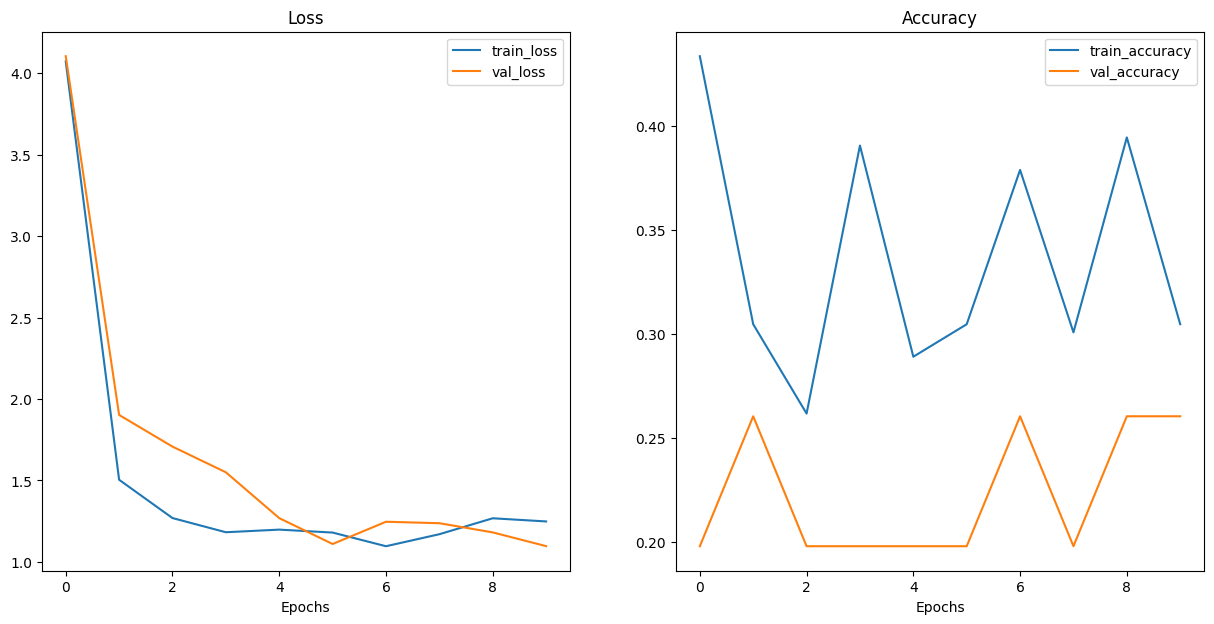

In [37]:
# plot loss curves
from core.utils import plot_loss_curves

plot_loss_curves(results)

## Using a pretrained ViT for the same dataset

In [38]:
# get pretrained weights for ViT-base
from torchvision.models import vit_b_16, ViT_B_16_Weights as pretrained_weights

pretrained_vit = vit_b_16(weights=pretrained_weights.DEFAULT).to(device)

# freeze params
for params in pretrained_vit.parameters():
    params.requires_grad = False
    
# set seed and classifier head for our task
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

summary(
    model=pretrained_vit,
    input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Prepare again the data:

In [39]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
print(f'image path: {image_path}')

train_dir = image_path / "train"
test_dir = image_path / "test"

# transform the data based on the transformation
# from the pretrained ViT
pretrained_vit_transforms = pretrained_weights.DEFAULT.transforms()
print(f"Pretrained ViT transforms: {pretrained_vit_transforms}")

train_dataloader, val_loader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=32,
    transforms=pretrained_vit_transforms
)

[INFO] ../data/pizza_steak_sushi directory exists, skipping download.
image path: ../data/pizza_steak_sushi
Pretrained ViT transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Class names: ['pizza', 'steak', 'sushi']


And now the training part:

In [40]:
training_args = TrainingArgs(
    n_epochs=10,
    device=device
)

loss_fn = nn.CrossEntropyLoss()

optim = t.optim.Adam(
    params=pretrained_vit.parameters(),
    lr=1e-3,
    # betas=(0.9, 0.999),
    # weight_decay=0.3
)

model_trainer = ModelTrainer(
    model=pretrained_vit,
    args=training_args,
    train_loader=train_dataloader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optim
)

results = model_trainer.train()

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Validation: loss = 1.2487, accuracy = 0.2282
--------------------------------------------------


Epoch 1/10: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s, loss=5.93, step=8]


Training: loss = 0.8180, accuracy = 0.6797


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Validation: loss = 0.5468, accuracy = 0.8665
--------------------------------------------------


Epoch 2/10: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s, loss=2.73, step=16] 


Training: loss = 0.3544, accuracy = 0.9414


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Validation: loss = 0.3535, accuracy = 0.9290
--------------------------------------------------


Epoch 3/10: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s, loss=1.71, step=24] 


Training: loss = 0.2162, accuracy = 0.9531


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Validation: loss = 0.2782, accuracy = 0.9081
--------------------------------------------------


Epoch 4/10: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s, loss=1.28, step=32] 


Training: loss = 0.1627, accuracy = 0.9609


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Validation: loss = 0.2385, accuracy = 0.8977
--------------------------------------------------


Epoch 5/10: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s, loss=1.01, step=40] 


Training: loss = 0.3108, accuracy = 0.8477


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Validation: loss = 0.2098, accuracy = 0.9176
--------------------------------------------------


Epoch 6/10: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s, loss=0.952, step=48] 


Training: loss = 0.1227, accuracy = 0.9648


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Validation: loss = 0.1789, accuracy = 0.9176
--------------------------------------------------


Epoch 7/10: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s, loss=0.901, step=56] 


Training: loss = 0.1193, accuracy = 0.9688


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Validation: loss = 0.1792, accuracy = 0.9176
--------------------------------------------------


Epoch 8/10: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s, loss=0.772, step=64]


Training: loss = 0.0979, accuracy = 0.9688


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Validation: loss = 0.1970, accuracy = 0.9280
--------------------------------------------------


Epoch 9/10: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s, loss=0.664, step=72]


Training: loss = 0.0844, accuracy = 0.9844


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Validation: loss = 0.2112, accuracy = 0.8977
--------------------------------------------------


Epoch 10/10: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s, loss=0.597, step=80] 


Training: loss = 0.0784, accuracy = 0.9922


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Validation: loss = 0.2174, accuracy = 0.9290
--------------------------------------------------
[INFO] Saving model to: ../models/model.pth


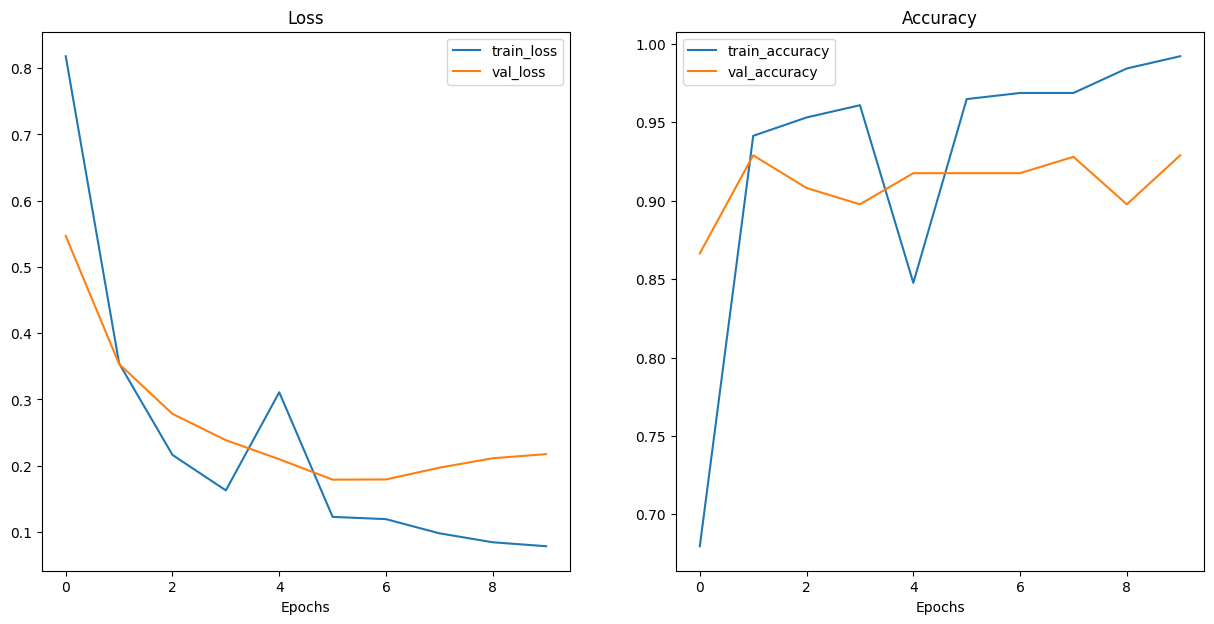

In [41]:
plot_loss_curves(results)

In [42]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("../models/model.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## Making predictions

torch.Size([1, 3, 224, 224])


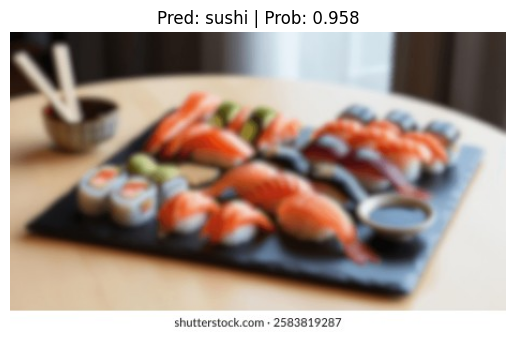

In [46]:
import requests

# Import function to make predictions on images and plot them
from core.utils import pred_and_plot_image

# load the pretrained weights from the training
pretrained_vit.load_state_dict(t.load("../models/model.pth"))

# Setup custom image path
custom_image_path = image_path / "blurred-sushi-platter-salmon-tuna-260nw-2583819287.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://www.shutterstock.com/image-photo/blurred-sushi-platter-salmon-tuna-260nw-2583819287.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    img_path=custom_image_path,
                    class_names=class_names,
                    device=device)